In [1]:
import numpy as np
import os
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from prettytable import PrettyTable
from matplotlib import pyplot as plt

import time

# video to frames

In [3]:
import os
import cv2

def extract_frames(video_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each video file in the folder
    for filename in os.listdir(video_folder):
        if filename.endswith(".mp4") or filename.endswith(".avi"):
            video_path = os.path.join(video_folder, filename)
            video_name = os.path.splitext(filename)[0]

            # Create a subfolder for each video
            video_output_folder = os.path.join(output_folder, video_name)
            if not os.path.exists(video_output_folder):
                os.makedirs(video_output_folder)

            # Open the video file
            cap = cv2.VideoCapture(video_path)
            frame_count = 0

            # Read and process each frame
            while(cap.isOpened()):
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Perform your processing here to identify words and numbers in the frame
                # For simplicity, let's just save every 16th frame
                if frame_count % 16 == 0:
                    output_frame_path = os.path.join(video_output_folder, f"{video_name}_frame_{frame_count}.jpg")
                    cv2.imwrite(output_frame_path, frame)

                frame_count += 1

            cap.release()

# Example usage:
video_dataset_folder = "D:\\FINAL YEAR PROJECT\\Dataset2.0"
output_frames_folder = "D:\\FINAL YEAR PROJECT\\Frames"
extract_frames(video_dataset_folder, output_frames_folder)


# Model Building

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, TimeDistributed, LSTM, Dense, BatchNormalization, Flatten

# Define constants
IMAGE_SIZE = (96, 72)
BATCH_SIZE = 16
EPOCHS = 400
NUM_CLASSES = 17
TRAIN_DATA_DIR = "D:\\New Dataset Lip Movement Projec\\FINAL YEAR PROJECT\\Frames"

# Define data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load and preprocess the data
train_generator = datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


# Define the CNN-RNN model
model_cnn_rnn = Sequential()

# CNN block
model_cnn_rnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model_cnn_rnn.add(MaxPooling2D((2, 2)))
model_cnn_rnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_rnn.add(MaxPooling2D((2, 2)))
model_cnn_rnn.add(Conv2D(256, (3, 3), activation='relu'))
model_cnn_rnn.add(MaxPooling2D((2, 2)))
model_cnn_rnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn_rnn.add(MaxPooling2D((2, 2)))

# Time-distributed layer to process each frame independently
model_cnn_rnn.add(TimeDistributed(Flatten()))

# RNN block
model_cnn_rnn.add(LSTM(64, return_sequences=True))
model_cnn_rnn.add(LSTM(32))

# Fully connected layer
model_cnn_rnn.add(Dense(512, activation='relu'))
model_cnn_rnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
model_cnn_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn_rnn.summary()


Found 127 images belonging to 17 classes.


Found 22 images belonging to 17 classes.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 70, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 35, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 33, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 14, 256)       147712    
                                                                 
 max_pooling

# model Training

In [3]:
# Start the timer
start_time = time.time()

# Train the model
history_cnn_rnn = model_cnn_rnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

model_cnn_rnn.save('cnn_rnn.h5')
# Stop the timer
end_time = time.time()

# Compute the computational time
comp_time = end_time - start_time

# Evaluate the model
train_loss_cnn_rnn, train_acc_cnn_rnn = model_cnn_rnn.evaluate(train_generator)
val_loss_cnn_rnn, val_acc_cnn_rnn = model_cnn_rnn.evaluate(validation_generator)

print(f'Training Accuracy (CNN-RNN): {train_acc_cnn_rnn * 100}')
print(f'Validation Accuracy (CNN-RNN): {val_acc_cnn_rnn * 100}')
print(f'Training time (CNN-RNN): {comp_time}')

Epoch 1/400


7/7 [==============================] - 5s 230ms/step - loss: 2.8413 - accuracy: 0.0180 - val_loss: 2.8322 - val_accuracy: 0.1250
Epoch 2/400
7/7 [==============================] - 1s 95ms/step - loss: 2.8341 - accuracy: 0.0721 - val_loss: 2.8334 - val_accuracy: 0.0000e+00
Epoch 3/400
7/7 [==============================] - 1s 93ms/step - loss: 2.8337 - accuracy: 0.0631 - val_loss: 2.8308 - val_accuracy: 0.0625
Epoch 4/400
7/7 [==============================] - 1s 93ms/step - loss: 2.8322 - accuracy: 0.0811 - val_loss: 2.8305 - val_accuracy: 0.0625
Epoch 5/400
7/7 [==============================] - 1s 92ms/step - loss: 2.8318 - accuracy: 0.0811 - val_loss: 2.8315 - val_accuracy: 0.0625
Epoch 6/400
7/7 [==============================] - 1s 100ms/step - loss: 2.8297 - accuracy: 0.0450 - val_loss: 2.8330 - val_accuracy: 0.0625
Epoch 7/400
7/7 [==============================] - 1s 95ms/step - loss: 2.8296 - accuracy: 0.0721 - val_loss: 2.8290 - val_accuracy: 0.0625
Epoch 8/400


c:\Users\ksaqu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 16ms/step - loss: 2.9350 - accuracy: 0.4545
Training Accuracy (CNN-RNN): 100.0
Validation Accuracy (CNN-RNN): 45.45454680919647
Training time (CNN-RNN): 287.2134816646576


# Training Graph

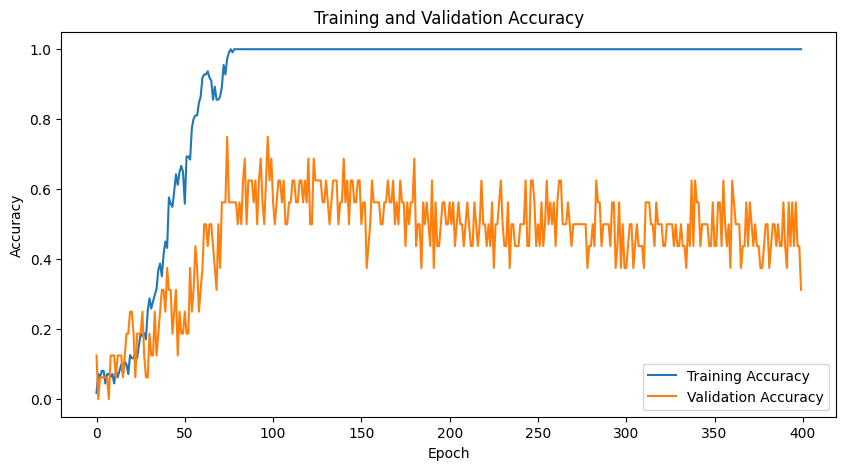

In [4]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_cnn_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ROC curve

2/2 [==============================] - 1s 5ms/step


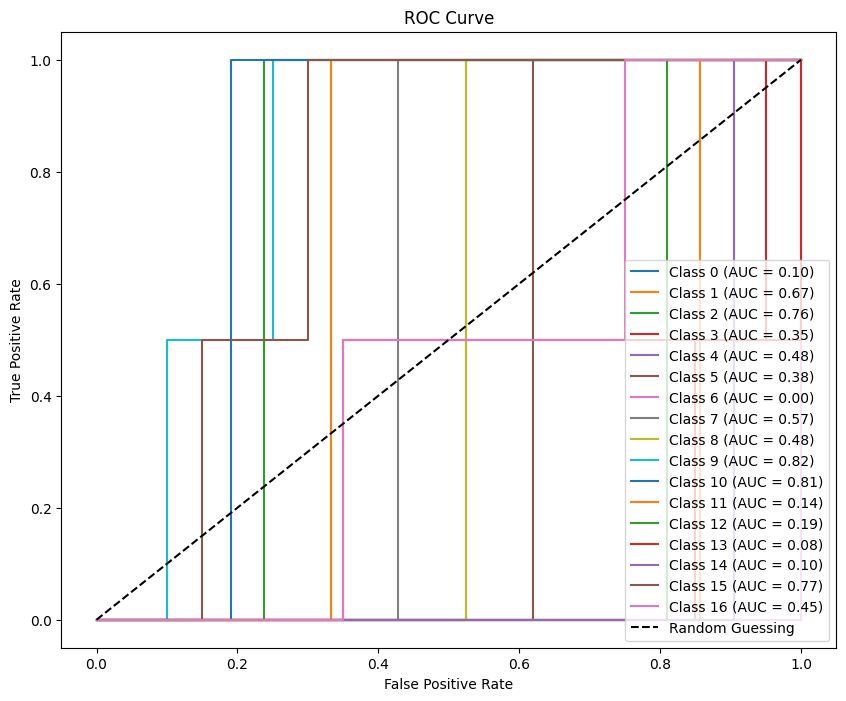

In [5]:
y_pred = model_cnn_rnn.predict(validation_generator)
y_true = validation_generator.classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# confusion Matrix

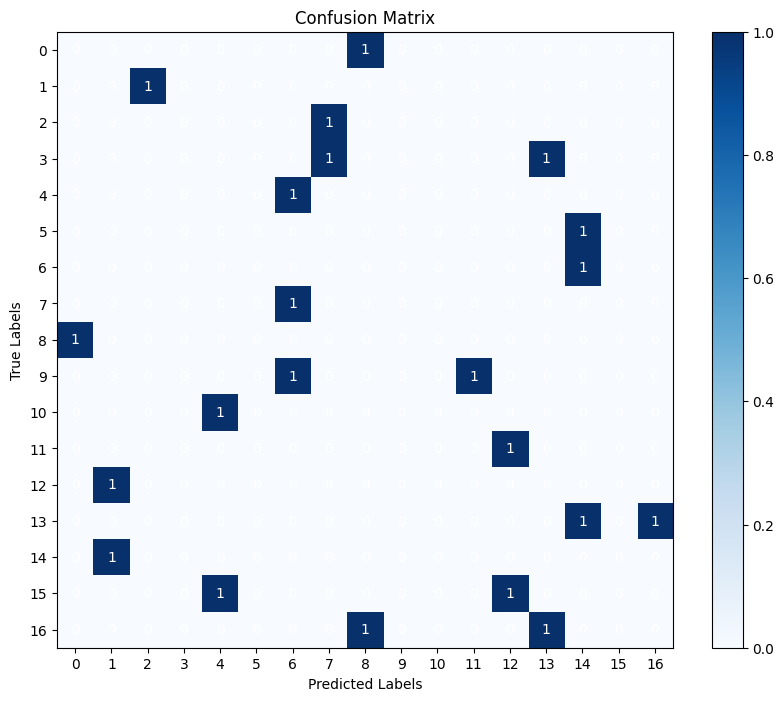

In [6]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(NUM_CLASSES))
plt.yticks(np.arange(NUM_CLASSES))
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

In [4]:
model_cnn_rnn.load_weights('D:\\New Dataset Lip Movement Projec\\FINAL YEAR PROJECT\\CNN_RNN\\cnn_rnn.h5')

# f1 Score

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from prettytable import PrettyTable
import pandas as pd

# Assuming you already have the necessary variables defined in your code
train_predictions = model_cnn_rnn.predict(train_generator)
validation_predictions = model_cnn_rnn.predict(validation_generator)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
validation_pred_labels = np.argmax(validation_predictions, axis=1)

# True labels for training and validation sets
train_true_labels = train_generator.classes
validation_true_labels = validation_generator.classes

# Calculate metrics
train_report = classification_report(train_true_labels, train_pred_labels, target_names=train_generator.class_indices)
validation_report = classification_report(validation_true_labels, validation_pred_labels, target_names=validation_generator.class_indices)

# Additional metrics using confusion matrix
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
validation_conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

# Calculate precision, recall, F1 score, and support
train_precision, train_recall, train_f1_score, train_support = precision_recall_fscore_support(train_true_labels, train_pred_labels)
validation_precision, validation_recall, validation_f1_score, validation_support = precision_recall_fscore_support(validation_true_labels, validation_pred_labels)

# Create PrettyTable for training metrics
train_table = PrettyTable()
train_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with training metrics
for class_name, precision, recall, f1_score, support in zip(
        train_generator.class_indices.keys(),
        train_precision,
        train_recall,
        train_f1_score,
        train_support
):
    train_table.add_row([class_name, precision, recall, f1_score, support])

# Create PrettyTable for validation metrics
validation_table = PrettyTable()
validation_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with validation metrics
for class_name, precision, recall, f1_score, support in zip(
        validation_generator.class_indices.keys(),
        validation_precision,
        validation_recall,
        validation_f1_score,
        validation_support
):
    validation_table.add_row([class_name, precision, recall, f1_score, support])

# Print tables
print("Training Metrics:")
print(train_table)

print("\nValidation Metrics:")
print(validation_table)

# ... (your existing code)

# Create DataFrames for training and validation metrics
train_df = pd.DataFrame({
    'Dataset': 'Training',
    'Class': list(train_generator.class_indices.keys()),
    'Precision': train_precision,
    'Recall': train_recall,
    'F1 Score': train_f1_score,
    'Support': train_support
})

validation_df = pd.DataFrame({
    'Dataset': 'Validation',
    'Class': list(validation_generator.class_indices.keys()),
    'Precision': validation_precision,
    'Recall': validation_recall,
    'F1 Score': validation_f1_score,
    'Support': validation_support
})

# Concatenate DataFrames
combined_df = pd.concat([train_df, validation_df], ignore_index=True)

# Save combined DataFrame to an Excel sheet
combined_excel_path = 'combined_metrics.xlsx'
combined_df.to_excel(combined_excel_path, index=False)

print(f"Combined metrics saved to {combined_excel_path}")


2/2 [==============================] - 0s 6ms/step
Training Metrics:
+-------+---------------------+---------------------+---------------------+---------+
| Class |      Precision      |        Recall       |       F1 Score      | Support |
+-------+---------------------+---------------------+---------------------+---------+
|   0   | 0.14285714285714285 | 0.14285714285714285 | 0.14285714285714285 |    7    |
|   1   |        0.125        |        0.125        |        0.125        |    8    |
|   10  |         0.0         |         0.0         |         0.0         |    6    |
|   2   |  0.2222222222222222 |  0.2222222222222222 |  0.2222222222222222 |    9    |
|   3   | 0.14285714285714285 | 0.14285714285714285 | 0.14285714285714285 |    7    |
|   4   |         0.0         |         0.0         |         0.0         |    8    |
|   5   |         0.0         |         0.0         |         0.0         |    6    |
|   6   |         0.0         |         0.0         |         0.0      

c:\Users\ksaqu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ksaqu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ksaqu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Combined metrics saved to combined_metrics.xlsx
